# If you are a music store manager
In this project we will use Chinook DB to to analyse some questions. chinook DB can be found here in github - 
https://github.com/lerocha/chinook-database

The projects uses sqlite and pandas dataframe. The integration with SQLite makes it easier to excute select, filter and sort commands in the Db, while plotting the data and groupby are more convienient in pandas.

We will explore a series of business questions and analyse the data to find answers.|

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as mp
import sqlite3

## Establish connection to the database and create basic functions
    1) We will use sqlite inbuilt context manager to establish connection to the database, 
        so that we do not overwrite on the any of the tables.
    2) we will write a functions that is used to run queries that return non table objects like views
    3) we will write a funciton that gives us a list of all table and view in the DB



In [330]:
db_file = '/Users/Suha/Projects/TestGitHub/Chinook/chinook-database-master/ChinookDatabase/DataSources/Chinook_Sqlite.sqlite'

#make a funciton to use context manager to connect to the database and reutrns the result as pd dataframe
def run_query(q):
    with sqlite3.connect(db_file) as conn:
        return pd.read_sql_query(q,conn)

# make a function to run queries that do not return table but views
def run_command(c):
    with sqlite3.connect(db_file) as conn:
        conn.isolation_level = None # this commits all the changes in the DB before the command is executed
        conn.execute(c)             # this executes the command that is passed in as a parameter
        
# make function to show the list of table and the view in db
def show_table():
    q = '''SELECT 
                Name
                , Type
            FROM sqlite_master
            WHERE type IN ('table','view');'''
    return run_query(q)

show_table()

q1 = '''select * from track'''
q2 = '''select * from InvoiceLine'''
run_query(q1).head()

,TrackId,Name,AlbumId,MediaTypeId,GenreId,Composer,Milliseconds,Bytes,UnitPrice
0,1,For Those About To Rock (We Salute You),1,1,1,"Angus Young, Malcolm Young, Brian Johnson",343719,11170334,0.99
1,2,Balls to the Wall,2,2,1,None,342562,5510424,0.99
2,3,Fast As a Shark,3,2,1,"F. Baltes, S. Kaufman, U. Dirkscneider & W. Ho...",230619,3990994,0.99
3,4,Restless and Wild,3,2,1,"F. Baltes, R.A. Smith-Diesel, S. Kaufman, U. D...",252051,4331779,0.99
4,5,Princess of the Dawn,3,2,1,Deaffy & R.A. Smith-Diesel,375418,6290521,0.99


# Which genres sell the most tracks in the USA?


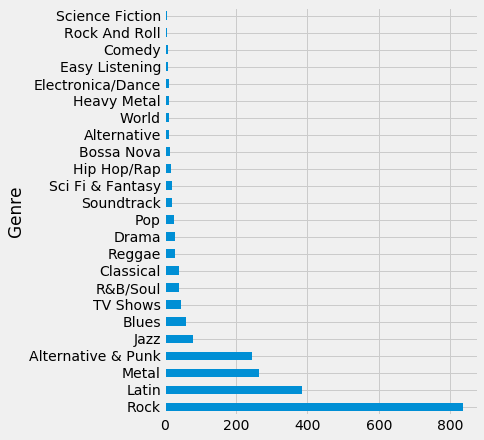

In [70]:
q3 = '''
    SELECT 
         c.Name Genre
        , sum(b.quantity) as Quantity 
       FROM Track a
    INNER JOIN InvoiceLine b
        ON a.TrackId = b.TrackId
    INNER JOIN Genre c
        ON a.GenreId = c.GenreId
    GROUP BY a.GenreId
    ORDER BY SUM(b.quantity) DESC
    
'''
# using Fivethirtyeight style to plot the result
plt.style.use('fivethirtyeight')

#Set 'Genre as index and plot it as a barchart
run_query(q3).set_index('Genre').plot(kind = 'barh', figsize = (5,7), legend = False)
plt.show()

## Plotting the distribution as a percentage

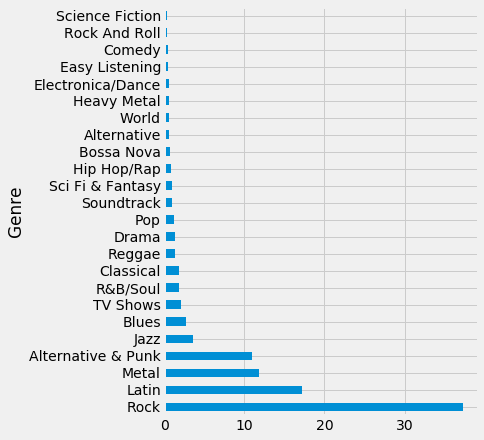

In [72]:
genre_sort = run_query(q3).set_index('Genre')
genre_sort['genre_pct'] = genre_sort['Quantity']/ genre_sort['Quantity'].sum()*100


genre_sort.plot(kind = 'barh', y ='genre_pct',  figsize = (5,7), legend = False)
plt.show()

Rock accounts for close to 37 percent of the genre followed by latin (17%), metal(13%) and alternative& punk (11%).
More than 50% of the qunatity is sold amongst these 4 genres.
let us look at the artist in these 4 genre having most sales


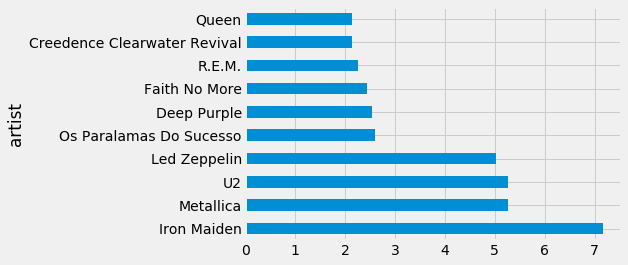

In [87]:
q4 = '''
    SELECT 
          d.name artist
        , sum(a.quantity) quantity
    FROM InvoiceLine a
    INNER JOIN Track b 
        ON a.TrackId = b.TrackId
    INNER JOIN Album c
        ON b.AlbumId = c.AlbumId
    INNER JOIN Artist d
        ON c.ArtistId = d.ArtistId
    INNER JOIN Genre e
        on b.GenreId = e.GenreId
    WHERE e.name IN ('Rock', 'Latin', 'Metal', 'Alternative & Punk')
    GROUP BY d.name
    ORDER BY 2 DESC
    '''
artist_sort = run_query(q4)
artist_sort['artist_pct'] = artist_sort['quantity'] / artist_sort['quantity'] .sum()*100
artist_sort.set_index('artist' , inplace = True)
#plotting the first 10 topp selling artist
artist_sort.head(10).plot(kind = 'barh', y ='artist_pct',legend = False)
plt.show()

The tracks of iron maiden, U2 and metallica are top selling in the top 4 genre.
Now lets us go ahead and see which artist sells the most tracks independent of genre.


In [89]:
q5 = '''
    SELECT 
          d.name artist
        , sum(a.quantity) quantity
    FROM InvoiceLine a
    INNER JOIN Track b 
        ON a.TrackId = b.TrackId
    INNER JOIN Album c
        ON b.AlbumId = c.AlbumId
    INNER JOIN Artist d
        ON c.ArtistId = d.ArtistId
    GROUP BY d.name
    ORDER BY 2 DESC
    '''
run_query(q5).head()


,artist,quantity
0,Iron Maiden,140
1,U2,107
2,Metallica,91
3,Led Zeppelin,87
4,Os Paralamas Do Sucesso,45


IronMaiden , U2 and metallic top the sales chart irrespective of the genre. The stores should purchase more of these.

## Who is the best performing employee?
Looking at the data the relevent columns for these analysis seem to be - 
    * Employee hire date - employees staying longer in the service should have sold more records. For the purpose of analysis, we will see the avg records sold per year given by - Total quantity sold/total years of service

In [108]:
q6 = '''
    SELECT 
        a.firstname || ' '||a.lastname employee_name
        , a.hiredate hiredate
        , DATE('now') - a.hiredate service_years
        , SUM(c.total)  total
        , SUM(c.total)/ (DATE('now') - a.hiredate) sales_per_year
    FROM employee a
    LEFT JOIN customer b
        ON a.employeeid = b. supportrepid
    LEFT JOIN invoice c
        ON b.customerid = c.customerid
    GROUP BY a.firstname || ' '||a.lastname , a.hiredate
    ORDER BY SUM(c.total) DESC
'''

run_query(q6)

,employee_name,hiredate,service_years,total,sales_per_year
0,Jane Peacock,2002-04-01 00:00:00,17,833.04,49.002353
1,Margaret Park,2003-05-03 00:00:00,16,775.40,48.462500
2,Steve Johnson,2003-10-17 00:00:00,16,720.16,45.010000
3,Andrew Adams,2002-08-14 00:00:00,17,NaN,NaN
4,Laura Callahan,2004-03-04 00:00:00,15,NaN,NaN
5,Michael Mitchell,2003-10-17 00:00:00,16,NaN,NaN
6,Nancy Edwards,2002-05-01 00:00:00,17,NaN,NaN
7,Robert King,2004-01-02 00:00:00,15,NaN,NaN


Most of the employee have service in the rage of 15-17 years. Only 3 employees seems to be in the front line and Jane is the top performing amongst them with an average of $49 sales per year.

## What can we find out from the sales data?
For this we will try to find out following information per country
* total number of customers
* total value of sales
* average value of sales per customer
* average order value

There are many countries where there is a simgle customer. For the purposes of the analysis, we will group them in 'Other'

In [140]:
# checking for duplicate id per customer
q7 = '''
    select
            firstname ||' '|| lastname 
            ,COUNT(customerid)
        FROM customer
        GROUP BY firstname ||' '|| lastname 
        HAVING COUNT(customerid) > 1
    
    '''
run_query(q7)
# none noted

,firstname ||' '|| lastname,COUNT(customerid)


In [241]:
q8 = '''

    SELECT 
         CASE 
             WHEN COUNT(distinct a.customerid)  = 1 THEN 'Other'
             ELSE a.country
          END  Country
        , COUNT(distinct a.customerid) total_customer
        , SUM(b.total) total_sales_per_country
 --       , COUNT(b.invoiceid) number_of_order
        , SUM(b.total)/ COUNT(distinct a.customerid) avg_sales_per_customer
        , SUM(b.total)/COUNT(b.invoiceid) avg_order_value
    FROM customer a
    LEFT JOIN invoice b
        ON a.customerid = b.customerid  
    GROUP BY a.country
    ORDER BY SUM(b.total) DESC

'''
country_sales = run_query(q8).set_index('Country')
country_sales.head()

,total_customer,total_sales_per_country,avg_sales_per_customer,avg_order_value
Country,,,,
USA,13,523.06,40.235385,5.747912
Canada,8,303.96,37.995000,5.427857
France,5,195.10,39.020000,5.574286
Brazil,5,190.10,38.020000,5.431429
Germany,4,156.48,39.120000,5.588571


Generally in sales the average order value per customer is higher, it reduces the customer aquisition cost. 
Let us look at the country where it would be more profitable to acquire the customers.
For this analysis, we will look at the countries that have more than 1 customer.

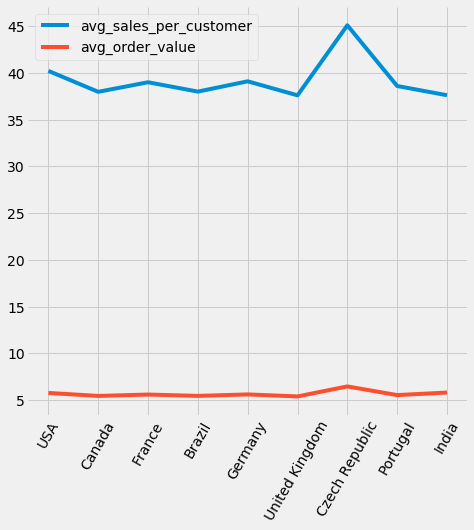

In [240]:
#Just selecting the major countries 
major_countries = ['USA', 'Canada', 'France', 'Brazil', 'Germany', 'United Kingdom', 'Czech Republic', 'Portugal', 'India']

plt.style.use('fivethirtyeight')
fig= plt.figure(figsize = (7,7))
ax = fig.add_subplot(1,1,1)
ax.plot(country_sales.loc[major_countries][['avg_sales_per_customer', 'avg_order_value']])
ax.legend(('avg_sales_per_customer', 'avg_order_value'), loc = 'best')

for (key, spine) in ax.spines.items():
    spine.set_visible(False)
plt.xticks(rotation = 60)
plt.show()


The average order value and the average sales per customer both are higher in United Kingdom. The store should put more investment in UK market to aquire more customers as the ROI is higher.


## Should the store buy all the tracks from the an album or buy the tracks individually?
Let us look at the percentage invoices which contain all the tracks from a single album 

In [329]:
q9 = '''

--Select all the tracks in the album
WITH album_track AS(
    SELECT 
         albumid 
        ,COUNT(trackid) as total_album_track
    FROM Track
    GROUP BY albumid
    )

--select all the albumbs with track count in an invoice
 , invoice_track AS(
    SELECT 
         a.invoiceid
        ,b.albumid
        ,count(a.trackid) total_track_per_album_per_purchase
    FROM invoiceline a
    LEFT JOIN track b
        ON a.trackid = b.trackid
    GROUP BY a.invoiceid , b.albumid
    )
    
    
--select only the invoices where full purchases are present 
SELECT 
      COUNT(*)  total_orders
    , SUM(full_album_purchase)   full_album_orders
    , SUM(full_album_purchase)/COUNT(*)*100  percentage_full_album_purchase
FROM (
     SELECT
            invoiceid
            , CASE 
                WHEN a.total_track_per_album_per_purchase = b.total_album_track 
                    THEN 1
                ELSE 0
             END full_album_purchase
        FROM invoice_track a
        LEFT JOIN album_track b 
            ON a.albumid = b.albumid
        GROUP BY invoiceid
        ) A

'''

run_query(q9)


,total_orders,full_album_orders,percentage_full_album_purchase
0,412,8,0


We found that only 8 out of 412 orders had full album purchase. It means that chinook store should to purchase popular tracks rather than full albums.